In [33]:
import torch
import torchvision
import sys
sys.path.append('..')
import failure_directions
import numpy as np
import torchvision.transforms as transforms
from torch.cuda.amp import autocast
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import yaml
from failure_directions.src.config_parsing import ffcv_read_check_override_config
import os
import failure_directions.src.pytorch_datasets as pytorch_datasets
import seaborn as sns
sns.set()

In [34]:
# Get hyperparameters
%cd ../failure_directions
with open("dataset_configs/supercifar100.yaml", 'r') as file:
    hparams = yaml.safe_load(file)
hparams = ffcv_read_check_override_config(hparams)
%cd ../example

print(hparams)

/mnt/cfs/home/saachij/src/failure-directions/failure_directions
Using default os_cache: False
Using default quasi_random: True
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default val_beton: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Using default cmnist: False
/mnt/cfs/home/saachij/src/failure-directions/example
{'mean': [125.307, 122.961, 113.8575], 'std': [51.5865, 50.847, 51.255], 'num_classes': 20, 'arch': 'resnet18', 'arch_type': 'cifar_resnet', 'batch_size': 512, 'num_workers': 1, 'imgsz': 32, 'train_beton': 'supercifar100/supercifar100_train.beton', 'test_beton': 'supercifar100/supercifar100_test.beton', 'train_img_decoder': 'simple', 'val_img_decoder': 'simple', 'shuffle': True, 'drop_last': True, 'train_aug': 'cifar_train_aug', 'training': {'epochs': 35, 'lr': 0.5, 'optimizer': {'momentum': 0.9, 'weight_decay': 0.0005}, 'lr_scheduler': {'type': 'cyclic', 'lr_peak_epoc

In [35]:
base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=np.array(hparams['mean'])/255, std=np.array(hparams['std'])/255)])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    base_transform
])

# For visualization
INV_NORM = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [255/x for x in hparams['std']]),
                                transforms.Normalize(mean = [-x /255 for x in hparams['mean']],
                                                     std = [ 1., 1., 1. ])])
TOIMAGE = transforms.Compose([INV_NORM, transforms.ToPILImage()])

In [36]:
# Get the indices dict
indices_dict = torch.load(os.path.join("../failure_directions/", "index_files/spurious_cifar100_with_unlabeled.pt"))
for k in indices_dict.keys():
    if indices_dict[k] is not None:
        print(k, len(indices_dict[k]))
indices_dict['no_shuffle_train_indices'] = indices_dict['train_indices']
minority_classes = torch.tensor(indices_dict['classes_to_drop'])

val_indices 10000
unlabeled_indices 20000
train_indices 17016
classes_to_drop 20


In [37]:
cifar100_orig_train = pytorch_datasets.SuperCIFAR100(root="/mnt/nfs/home/saachij/datasets/cifar100", 
                                               train=True, transform=train_transform)
cifar100_no_aug_train = pytorch_datasets.SuperCIFAR100(root="/mnt/nfs/home/saachij/datasets/cifar100", 
                                               train=True, transform=base_transform)
cifar100_orig_test = pytorch_datasets.SuperCIFAR100(root="/mnt/nfs/home/saachij/datasets/cifar100", 
                                                    train=False, transform=base_transform)

In [38]:
train_orig_subclasses = torch.tensor(cifar100_orig_train.subclass_targets) # subclasses from the original training dataset
train_orig_classes = torch.tensor(cifar100_orig_train.targets) # subclasses from the original training dataset
train_orig_is_minority = np.in1d(train_orig_subclasses.numpy(), minority_classes.numpy()) # indicator vector of examples that are part of the minority pop
test_orig_subclasses = torch.tensor(cifar100_orig_test.subclass_targets) # subclasses from the original training dataset
test_orig_classes = torch.tensor(cifar100_orig_test.targets) # subclasses from the original training dataset

In [39]:
# perform subsetting
dataset_splits = {}
for k in ['train', 'val', 'unlabeled', 'no_shuffle_train']:
    if k == 'train': # shuffle and augment
        subset_ds = cifar100_orig_train
    else:
        subset_ds = cifar100_no_aug_train
    subset_ds = torch.utils.data.Subset(subset_ds, indices_dict[f'{k}_indices'])
    subset_subclasses = train_orig_subclasses[indices_dict[f'{k}_indices']]
    subset_classes = train_orig_classes[indices_dict[f'{k}_indices']]
    is_minority = np.in1d(subset_subclasses.numpy(), minority_classes.numpy())
    dataset_splits[k] = {
        'ds': subset_ds, 
        'subclasses': subset_subclasses, 
        'classes': subset_classes,
        'is_minority': is_minority,
    }
dataset_splits['test'] = {
    'ds': cifar100_orig_test, 
    'subclasses': test_orig_subclasses, 
    'classes': test_orig_classes,
    'is_minority': np.in1d(test_orig_subclasses.numpy(), minority_classes.numpy())
}

In [40]:
for k, ds_dict in dataset_splits.items():
    print("---- ", k, "-----")
    print(f"Length:{len(ds_dict['subclasses'])}")
    print(f"Percent from minority classes:{ds_dict['is_minority'].mean():0.3f}")

----  train -----
Length:17016
Percent from minority classes:0.059
----  val -----
Length:10000
Percent from minority classes:0.198
----  unlabeled -----
Length:20000
Percent from minority classes:0.201
----  no_shuffle_train -----
Length:17016
Percent from minority classes:0.059
----  test -----
Length:10000
Percent from minority classes:0.200


## Train the base model

In [41]:
loaders = {
    k: torch.utils.data.DataLoader(dataset_splits[k]['ds'], batch_size=hparams['batch_size'], 
                                   shuffle=(k=='train'), drop_last=(k=='train'))
    for k in dataset_splits.keys()
}

In [42]:
def train_model(train_loader, val_loader, exp_name):
    build_fn = failure_directions.model_utils.BUILD_FUNCTIONS[hparams['arch_type']]
    model = build_fn(hparams['arch'], hparams['num_classes'])
    model = model.cuda()

    training_args=hparams['training']
    training_args['iters_per_epoch'] = len(train_loader)
    trainer = failure_directions.LightWeightTrainer(training_args=hparams['training'],
                                                    exp_name=exp_name, enable_logging=True,
                                                    bce=False, set_device=True)
    trainer.fit(model, train_loader, val_loader)
    return model

def evaluate_model(model, loader):
    with torch.no_grad():
        with autocast():
            gts, preds, confs = [], [], []
            for x, y, _ in tqdm(loader):
                x = x.cuda()
                logits = model(x)
                gts.append(y.cpu())
                preds.append(logits.argmax(-1).cpu())
                softmax_logits = nn.Softmax(dim=-1)(logits)
                confs.append(softmax_logits[torch.arange(logits.shape[0]), y].cpu())
    gts = torch.cat(gts).numpy()
    preds = torch.cat(preds).numpy()
    confs = torch.cat(confs).numpy()
    return {
        'gt': gts, 
        'preds': preds, 
        'confs': confs
    }

if you've already trained the model just load it here by uncommenting this cell


In [11]:
# build_fn = failure_directions.model_utils.BUILD_FUNCTIONS[hparams['arch_type']]
# path = "runs/base/version_0/checkpoints/checkpoint_last.pt"
# model = failure_directions.model_utils.load_model(path, build_fn)
# model = model.cuda()


otherwise train it here by running this cell

In [ ]:
# or train it here
model = train_model(loaders['train'], loaders['val'], exp_name='base')

evaluate model and check accuracy on the minority population

In [44]:
# evaluate
model = model.eval()
run_dict = {}
for split, loader in loaders.items():
    if split == 'train':
        continue
    out = evaluate_model(model, loader)
    run_dict[split] = out
    is_correct = out['gt'] == out['preds']
    overall_acc = is_correct.mean()
    subpop_acc = is_correct[dataset_splits[split]['is_minority']].mean()
    print(f"{split} || Overall {overall_acc:0.3f}\t Minority acc {subpop_acc:0.3f}")

100%|██████████| 20/20 [00:01<00:00, 13.81it/s]


val || Overall 0.693	 Minority acc 0.457


100%|██████████| 40/40 [00:02<00:00, 13.87it/s]


unlabeled || Overall 0.688	 Minority acc 0.444


100%|██████████| 34/34 [00:02<00:00, 13.86it/s]


no_shuffle_train || Overall 0.994	 Minority acc 0.980


100%|██████████| 20/20 [00:01<00:00, 14.44it/s]

test || Overall 0.696	 Minority acc 0.434


## Get the clip features

In [45]:
clip_processor = failure_directions.CLIPProcessor(ds_mean=hparams['mean'], ds_std=hparams['std'])
clip_features = {}
for split, loader in loaders.items():
    if loader == 'train':
        continue
    clip_features[split] = clip_processor.evaluate_clip_images(loader)

100%|██████████| 20/20 [00:02<00:00,  7.53it/s]


In [46]:
svm_fitter = failure_directions.SVMFitter()
svm_fitter.set_preprocess(clip_features['train'])
val_gts = run_dict['val']['gt']
val_preds = run_dict['val']['preds']
cv_scores = svm_fitter.fit(preds=val_preds, ys=val_gts, latents=clip_features['val'].numpy())

updating whitening


100%|██████████| 20/20 [00:07<00:00,  2.72it/s]


In [47]:
svm_predictions = {}
svm_decision_values = {}
for split, loader in loaders.items():
    if split == 'train':
        continue
    mask, dv = svm_fitter.predict(ys=run_dict[split]['gt'], latents=clip_features[split], compute_metrics=False)
    svm_predictions[split] = mask
    svm_decision_values[split] = dv

100%|██████████| 20/20 [00:00<00:00, 28.45it/s]


## Plot resulting how decision values correspond to minority population

In [48]:
def get_cdf(arr, xaxis):
    return np.array([arr[:k].mean() for k in xaxis])

confidence_cdfs = []
dv_cdfs = []
xaxis = np.arange(10, 500, 50)
for c in range(hparams['num_classes']):
    mask = run_dict['test']['gt'] == c
    confs = run_dict['test']['confs'][mask]
    dv = svm_decision_values['test'][mask]
    minority = dataset_splits['test']['is_minority'][mask]
    
    conf_order = minority[np.argsort(confs)]
    dv_order = minority[np.argsort(dv)]
    confidence_cdfs.append(get_cdf(conf_order, xaxis))
    dv_cdfs.append(get_cdf(dv_order, xaxis))
    
confidence_cdfs = np.stack(confidence_cdfs).mean(0)
dv_cdfs = np.stack(dv_cdfs).mean(0)

    

Text(0, 0.5, 'Fraction Minority Subclass')

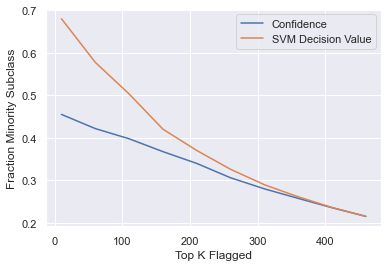

In [49]:
sns.lineplot(x=xaxis, y=confidence_cdfs, label='Confidence')
sns.lineplot(x=xaxis, y=dv_cdfs, label='SVM Decision Value')
plt.xlabel("Top K Flagged")
plt.ylabel("Fraction Minority Subclass")

## Intervention

In [50]:
K_TO_ADD = 75 # vary between 25 and 100. in the paper, this was done over 5 runs, just doing one here

In [51]:
extra_data_values = {
    'confidence': run_dict['unlabeled']['confs'],
    'SVM': svm_decision_values['unlabeled'],
    'random': np.random.random(len(run_dict['unlabeled']['confs'])),
}
extra_data_targets = dataset_splits['unlabeled']['classes']
extra_data_indices = indices_dict['unlabeled_indices']
extra_minority_indices = dataset_splits['unlabeled']['is_minority']

In [52]:
extra_selected_indices = {k: [indices_dict['train_indices']] for k in extra_data_values.keys()}
for c in range(hparams['num_classes']):
    mask = extra_data_targets == c
    for k, vals in extra_data_values.items():
        candidate_indices = extra_data_indices[mask]
        candidate_indices = candidate_indices[np.argsort(vals[mask])][:K_TO_ADD]
        extra_selected_indices[k].append(candidate_indices)
extra_selected_indices = {k: torch.cat(v) for k, v in extra_selected_indices.items()}

In [30]:
intervention_results = {}
for k, new_train_indices in extra_selected_indices.items():
    subset_ds = torch.utils.data.Subset(cifar100_orig_train, new_train_indices)
    new_loader = torch.utils.data.DataLoader(subset_ds, 
                                   batch_size=hparams['batch_size'], 
                                   shuffle=True, 
                                   drop_last=True)
    intervention_model = train_model(new_loader, loaders['val'], exp_name=k)
    result = evaluate_model(intervention_model, loaders['test'])
    intervention_results[k] = result
    is_correct = result['gt'] == result['preds']
    minority_mask = dataset_splits['test']['is_minority']
    print(k, is_correct[minority_mask].mean())

logging in  runs/confidence/version_0


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s, loss=4.38, acc=0.129] 


LR: 0.1, Train Loss: 2.7858, Train Acc: 0.1565, Val Loss: 7.1540, Val Acc: 0.0820


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 13.78it/s, loss=2.28, acc=0.368] 


LR: 0.2, Train Loss: 2.5223, Train Acc: 0.2353, Val Loss: 2.4916, Val Acc: 0.2346


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 13.78it/s, loss=2.46, acc=0.188]  


LR: 0.3, Train Loss: 2.3965, Train Acc: 0.2694, Val Loss: 2.4335, Val Acc: 0.2661


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 13.83it/s, loss=2.57, acc=0.0662]


LR: 0.4, Train Loss: 2.2809, Train Acc: 0.2982, Val Loss: 2.3763, Val Acc: 0.2809


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 13.72it/s, loss=2.5, acc=0.0919] 


LR: 0.5, Train Loss: 2.2161, Train Acc: 0.3191, Val Loss: 2.4028, Val Acc: 0.2630


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, loss=2.23, acc=0.349]


LR: 0.48333333333333334, Train Loss: 2.1000, Train Acc: 0.3503, Val Loss: 2.0946, Val Acc: 0.3456


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s, loss=2.07, acc=0.357]


LR: 0.4666666666666667, Train Loss: 1.9728, Train Acc: 0.3836, Val Loss: 2.0226, Val Acc: 0.3692


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 13.74it/s, loss=2.69, acc=0.0735]


LR: 0.45, Train Loss: 1.8674, Train Acc: 0.4206, Val Loss: 1.9545, Val Acc: 0.3880


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s, loss=2.1, acc=0.305] 


LR: 0.43333333333333335, Train Loss: 1.7816, Train Acc: 0.4435, Val Loss: 1.8490, Val Acc: 0.4217


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 13.82it/s, loss=2.07, acc=0.408]


LR: 0.41666666666666663, Train Loss: 1.6957, Train Acc: 0.4734, Val Loss: 1.8723, Val Acc: 0.4156


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, loss=1.89, acc=0.382] 


LR: 0.4, Train Loss: 1.5904, Train Acc: 0.4972, Val Loss: 1.7774, Val Acc: 0.4553


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 13.74it/s, loss=1.68, acc=0.43]  


LR: 0.3833333333333333, Train Loss: 1.5103, Train Acc: 0.5252, Val Loss: 1.5945, Val Acc: 0.5013


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s, loss=1.81, acc=0.357] 


LR: 0.3666666666666667, Train Loss: 1.4247, Train Acc: 0.5490, Val Loss: 1.6739, Val Acc: 0.4827


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 13.78it/s, loss=2.38, acc=0.342]


LR: 0.35, Train Loss: 1.3688, Train Acc: 0.5648, Val Loss: 1.7812, Val Acc: 0.4644


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, loss=2.03, acc=0.312] 


LR: 0.3333333333333333, Train Loss: 1.2970, Train Acc: 0.5923, Val Loss: 1.7788, Val Acc: 0.4667


Val Epoch: 15: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, loss=1.24, acc=0.471] 


LR: 0.31666666666666665, Train Loss: 1.2316, Train Acc: 0.6058, Val Loss: 1.6147, Val Acc: 0.5141


Val Epoch: 16: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, loss=1.77, acc=0.445] 


LR: 0.3, Train Loss: 1.1585, Train Acc: 0.6336, Val Loss: 1.4430, Val Acc: 0.5451


Val Epoch: 17: 100%|██████████| 20/20 [00:01<00:00, 13.84it/s, loss=1.26, acc=0.559] 


LR: 0.2833333333333333, Train Loss: 1.0989, Train Acc: 0.6491, Val Loss: 1.3751, Val Acc: 0.5694


Val Epoch: 18: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s, loss=1.66, acc=0.489] 


LR: 0.26666666666666666, Train Loss: 1.0510, Train Acc: 0.6669, Val Loss: 1.3756, Val Acc: 0.5740


Val Epoch: 19: 100%|██████████| 20/20 [00:01<00:00, 13.78it/s, loss=1.97, acc=0.346] 


LR: 0.25, Train Loss: 0.9752, Train Acc: 0.6894, Val Loss: 1.4947, Val Acc: 0.5459


Val Epoch: 20: 100%|██████████| 20/20 [00:01<00:00, 13.79it/s, loss=1.57, acc=0.533] 


LR: 0.23333333333333334, Train Loss: 0.9282, Train Acc: 0.7023, Val Loss: 1.3639, Val Acc: 0.5741


Val Epoch: 21: 100%|██████████| 20/20 [00:01<00:00, 13.79it/s, loss=2.24, acc=0.338] 


LR: 0.21666666666666667, Train Loss: 0.8617, Train Acc: 0.7253, Val Loss: 1.4468, Val Acc: 0.5718


Val Epoch: 22: 100%|██████████| 20/20 [00:01<00:00, 13.78it/s, loss=1.09, acc=0.658] 


LR: 0.2, Train Loss: 0.8106, Train Acc: 0.7407, Val Loss: 1.2517, Val Acc: 0.6064


Val Epoch: 23: 100%|██████████| 20/20 [00:01<00:00, 13.78it/s, loss=1.55, acc=0.529] 


LR: 0.18333333333333335, Train Loss: 0.7541, Train Acc: 0.7560, Val Loss: 1.3384, Val Acc: 0.5988


Val Epoch: 24: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s, loss=1.37, acc=0.548] 


LR: 0.16666666666666663, Train Loss: 0.6934, Train Acc: 0.7748, Val Loss: 1.2468, Val Acc: 0.6308


Val Epoch: 25: 100%|██████████| 20/20 [00:01<00:00, 13.80it/s, loss=2, acc=0.412]    


LR: 0.14999999999999997, Train Loss: 0.6195, Train Acc: 0.7971, Val Loss: 1.2310, Val Acc: 0.6351


Val Epoch: 26: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s, loss=1.17, acc=0.607] 


LR: 0.1333333333333333, Train Loss: 0.5465, Train Acc: 0.8204, Val Loss: 1.2139, Val Acc: 0.6493


Val Epoch: 27: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, loss=1.06, acc=0.676]


LR: 0.11666666666666664, Train Loss: 0.4866, Train Acc: 0.8426, Val Loss: 1.2257, Val Acc: 0.6562


Val Epoch: 28: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s, loss=0.923, acc=0.721]


LR: 0.09999999999999998, Train Loss: 0.4069, Train Acc: 0.8635, Val Loss: 1.3236, Val Acc: 0.6361


Val Epoch: 29: 100%|██████████| 20/20 [00:01<00:00, 13.78it/s, loss=1.52, acc=0.562] 


LR: 0.08333333333333331, Train Loss: 0.3400, Train Acc: 0.8886, Val Loss: 1.2470, Val Acc: 0.6567


Val Epoch: 30: 100%|██████████| 20/20 [00:01<00:00, 13.76it/s, loss=1.47, acc=0.603] 


LR: 0.06666666666666665, Train Loss: 0.2687, Train Acc: 0.9117, Val Loss: 1.2896, Val Acc: 0.6574


Val Epoch: 31: 100%|██████████| 20/20 [00:01<00:00, 13.83it/s, loss=1.27, acc=0.643] 


LR: 0.04999999999999999, Train Loss: 0.2028, Train Acc: 0.9363, Val Loss: 1.1678, Val Acc: 0.6902


Val Epoch: 32: 100%|██████████| 20/20 [00:01<00:00, 13.74it/s, loss=1.35, acc=0.64]  


LR: 0.033333333333333326, Train Loss: 0.1387, Train Acc: 0.9607, Val Loss: 1.1687, Val Acc: 0.6929


Val Epoch: 33: 100%|██████████| 20/20 [00:01<00:00, 13.78it/s, loss=1.09, acc=0.688] 


LR: 0.016666666666666663, Train Loss: 0.0961, Train Acc: 0.9754, Val Loss: 1.1412, Val Acc: 0.7049


Val Epoch: 34: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, loss=1.2, acc=0.665]  


LR: 0.0, Train Loss: 0.0750, Train Acc: 0.9822, Val Loss: 1.1341, Val Acc: 0.7104


100%|██████████| 20/20 [00:01<00:00, 14.12it/s]


confidence 0.4985
logging in  runs/SVM/version_0


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 13.74it/s, loss=6.12, acc=0]      


LR: 0.1, Train Loss: 2.8522, Train Acc: 0.1444, Val Loss: 9.4503, Val Acc: 0.0802


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 13.70it/s, loss=2.8, acc=0.143]  


LR: 0.2, Train Loss: 2.5346, Train Acc: 0.2224, Val Loss: 2.8268, Val Acc: 0.1722


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 13.70it/s, loss=2.42, acc=0.103] 


LR: 0.3, Train Loss: 2.4217, Train Acc: 0.2497, Val Loss: 2.4289, Val Acc: 0.2563


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 13.81it/s, loss=1.57, acc=0.353] 


LR: 0.4, Train Loss: 2.2792, Train Acc: 0.2953, Val Loss: 2.5394, Val Acc: 0.2528


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 13.74it/s, loss=2.41, acc=0.147] 


LR: 0.5, Train Loss: 2.1965, Train Acc: 0.3235, Val Loss: 2.1570, Val Acc: 0.3363


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 13.76it/s, loss=1.54, acc=0.485] 


LR: 0.48333333333333334, Train Loss: 2.0744, Train Acc: 0.3571, Val Loss: 2.1744, Val Acc: 0.3192


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 13.73it/s, loss=3, acc=0.158]    


LR: 0.4666666666666667, Train Loss: 1.9616, Train Acc: 0.3856, Val Loss: 2.1912, Val Acc: 0.3404


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 13.79it/s, loss=1.86, acc=0.412]


LR: 0.45, Train Loss: 1.8682, Train Acc: 0.4161, Val Loss: 2.0812, Val Acc: 0.3564


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 13.76it/s, loss=2, acc=0.327]    


LR: 0.43333333333333335, Train Loss: 1.7746, Train Acc: 0.4400, Val Loss: 2.0006, Val Acc: 0.3802


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 13.78it/s, loss=1.61, acc=0.463]


LR: 0.41666666666666663, Train Loss: 1.6742, Train Acc: 0.4692, Val Loss: 1.8647, Val Acc: 0.4254


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 13.79it/s, loss=1.13, acc=0.632]


LR: 0.4, Train Loss: 1.5815, Train Acc: 0.4999, Val Loss: 1.7126, Val Acc: 0.4490


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 13.80it/s, loss=2.32, acc=0.357]


LR: 0.3833333333333333, Train Loss: 1.4797, Train Acc: 0.5258, Val Loss: 1.8604, Val Acc: 0.4309


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, loss=1.71, acc=0.419]


LR: 0.3666666666666667, Train Loss: 1.3926, Train Acc: 0.5552, Val Loss: 1.6957, Val Acc: 0.4664


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 13.76it/s, loss=2.07, acc=0.301] 


LR: 0.35, Train Loss: 1.3047, Train Acc: 0.5775, Val Loss: 1.6541, Val Acc: 0.4763


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 13.79it/s, loss=1.22, acc=0.544] 


LR: 0.3333333333333333, Train Loss: 1.2329, Train Acc: 0.6025, Val Loss: 1.5446, Val Acc: 0.5223


Val Epoch: 15: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s, loss=1.01, acc=0.651] 


LR: 0.31666666666666665, Train Loss: 1.1463, Train Acc: 0.6311, Val Loss: 1.5522, Val Acc: 0.5250


Val Epoch: 16: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, loss=1.61, acc=0.518] 


LR: 0.3, Train Loss: 1.0740, Train Acc: 0.6545, Val Loss: 1.6012, Val Acc: 0.5309


Val Epoch: 17: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, loss=1.82, acc=0.419] 


LR: 0.2833333333333333, Train Loss: 1.0206, Train Acc: 0.6700, Val Loss: 1.4996, Val Acc: 0.5379


Val Epoch: 18: 100%|██████████| 20/20 [00:01<00:00, 13.79it/s, loss=1.21, acc=0.654] 


LR: 0.26666666666666666, Train Loss: 0.9602, Train Acc: 0.6878, Val Loss: 1.4086, Val Acc: 0.5581


Val Epoch: 19: 100%|██████████| 20/20 [00:01<00:00, 13.76it/s, loss=1.78, acc=0.467]


LR: 0.25, Train Loss: 0.8911, Train Acc: 0.7076, Val Loss: 1.4579, Val Acc: 0.5553


Val Epoch: 20: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, loss=1.54, acc=0.551] 


LR: 0.23333333333333334, Train Loss: 0.8465, Train Acc: 0.7240, Val Loss: 1.4108, Val Acc: 0.5737


Val Epoch: 21: 100%|██████████| 20/20 [00:01<00:00, 13.79it/s, loss=0.976, acc=0.68] 


LR: 0.21666666666666667, Train Loss: 0.7812, Train Acc: 0.7450, Val Loss: 1.3272, Val Acc: 0.6083


Val Epoch: 22: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s, loss=1.67, acc=0.559] 


LR: 0.2, Train Loss: 0.7153, Train Acc: 0.7661, Val Loss: 1.4079, Val Acc: 0.6004


Val Epoch: 23: 100%|██████████| 20/20 [00:01<00:00, 13.78it/s, loss=1.38, acc=0.625]


LR: 0.18333333333333335, Train Loss: 0.6615, Train Acc: 0.7816, Val Loss: 1.4299, Val Acc: 0.5876


Val Epoch: 24: 100%|██████████| 20/20 [00:01<00:00, 13.79it/s, loss=0.909, acc=0.757]


LR: 0.16666666666666663, Train Loss: 0.5914, Train Acc: 0.8067, Val Loss: 1.3948, Val Acc: 0.5984


Val Epoch: 25: 100%|██████████| 20/20 [00:01<00:00, 13.78it/s, loss=1.29, acc=0.64]  


LR: 0.14999999999999997, Train Loss: 0.5392, Train Acc: 0.8228, Val Loss: 1.4101, Val Acc: 0.6084


Val Epoch: 26: 100%|██████████| 20/20 [00:01<00:00, 13.70it/s, loss=0.975, acc=0.691]


LR: 0.1333333333333333, Train Loss: 0.4634, Train Acc: 0.8465, Val Loss: 1.3412, Val Acc: 0.6249


Val Epoch: 27: 100%|██████████| 20/20 [00:01<00:00, 13.74it/s, loss=1.12, acc=0.673] 


LR: 0.11666666666666664, Train Loss: 0.4001, Train Acc: 0.8661, Val Loss: 1.4192, Val Acc: 0.6228


Val Epoch: 28: 100%|██████████| 20/20 [00:01<00:00, 13.73it/s, loss=0.68, acc=0.801] 


LR: 0.09999999999999998, Train Loss: 0.3552, Train Acc: 0.8822, Val Loss: 1.3467, Val Acc: 0.6511


Val Epoch: 29: 100%|██████████| 20/20 [00:01<00:00, 13.79it/s, loss=0.702, acc=0.776]


LR: 0.08333333333333331, Train Loss: 0.2855, Train Acc: 0.9046, Val Loss: 1.2864, Val Acc: 0.6679


Val Epoch: 30: 100%|██████████| 20/20 [00:01<00:00, 13.72it/s, loss=1.14, acc=0.654] 


LR: 0.06666666666666665, Train Loss: 0.2052, Train Acc: 0.9352, Val Loss: 1.1814, Val Acc: 0.6872


Val Epoch: 31: 100%|██████████| 20/20 [00:01<00:00, 13.80it/s, loss=0.815, acc=0.787]


LR: 0.04999999999999999, Train Loss: 0.1450, Train Acc: 0.9578, Val Loss: 1.2273, Val Acc: 0.6904


Val Epoch: 32: 100%|██████████| 20/20 [00:01<00:00, 13.76it/s, loss=0.974, acc=0.717]


LR: 0.033333333333333326, Train Loss: 0.1065, Train Acc: 0.9705, Val Loss: 1.1834, Val Acc: 0.7036


Val Epoch: 33: 100%|██████████| 20/20 [00:01<00:00, 13.79it/s, loss=0.992, acc=0.717]


LR: 0.016666666666666663, Train Loss: 0.0739, Train Acc: 0.9817, Val Loss: 1.1670, Val Acc: 0.7112


Val Epoch: 34: 100%|██████████| 20/20 [00:01<00:00, 13.76it/s, loss=1.05, acc=0.706] 


LR: 0.0, Train Loss: 0.0560, Train Acc: 0.9885, Val Loss: 1.1628, Val Acc: 0.7139


100%|██████████| 20/20 [00:01<00:00, 14.42it/s]


SVM 0.519
logging in  runs/random/version_0


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 13.74it/s, loss=12.2, acc=0]      


LR: 0.1, Train Loss: 2.8160, Train Acc: 0.1550, Val Loss: 13.5366, Val Acc: 0.0672


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 13.79it/s, loss=2.49, acc=0.191] 


LR: 0.2, Train Loss: 2.4810, Train Acc: 0.2400, Val Loss: 2.5091, Val Acc: 0.2371


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 13.76it/s, loss=2.34, acc=0.221] 


LR: 0.3, Train Loss: 2.3377, Train Acc: 0.2771, Val Loss: 2.3598, Val Acc: 0.2646


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, loss=1.58, acc=0.312] 


LR: 0.4, Train Loss: 2.2212, Train Acc: 0.3171, Val Loss: 2.9213, Val Acc: 0.2170


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 13.78it/s, loss=1.97, acc=0.279]


LR: 0.5, Train Loss: 2.0915, Train Acc: 0.3533, Val Loss: 2.2850, Val Acc: 0.2988


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s, loss=2.68, acc=0.154]


LR: 0.48333333333333334, Train Loss: 1.9977, Train Acc: 0.3751, Val Loss: 2.1228, Val Acc: 0.3327


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 13.81it/s, loss=3.03, acc=0.0993]


LR: 0.4666666666666667, Train Loss: 1.8603, Train Acc: 0.4176, Val Loss: 2.1183, Val Acc: 0.3430


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s, loss=1.76, acc=0.404]


LR: 0.45, Train Loss: 1.7540, Train Acc: 0.4475, Val Loss: 2.0452, Val Acc: 0.3624


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, loss=2.16, acc=0.257]


LR: 0.43333333333333335, Train Loss: 1.6236, Train Acc: 0.4873, Val Loss: 1.8436, Val Acc: 0.4339


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, loss=1.92, acc=0.386] 


LR: 0.41666666666666663, Train Loss: 1.5209, Train Acc: 0.5183, Val Loss: 1.9291, Val Acc: 0.4086


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, loss=1.24, acc=0.603]


LR: 0.4, Train Loss: 1.4037, Train Acc: 0.5547, Val Loss: 1.6956, Val Acc: 0.4619


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 13.81it/s, loss=1.79, acc=0.441] 


LR: 0.3833333333333333, Train Loss: 1.3326, Train Acc: 0.5708, Val Loss: 1.5860, Val Acc: 0.4971


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s, loss=2.41, acc=0.276]


LR: 0.3666666666666667, Train Loss: 1.2422, Train Acc: 0.6010, Val Loss: 2.1435, Val Acc: 0.3974


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 13.74it/s, loss=2.13, acc=0.335] 


LR: 0.35, Train Loss: 1.1582, Train Acc: 0.6287, Val Loss: 2.0362, Val Acc: 0.4346


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 13.74it/s, loss=1.28, acc=0.566] 


LR: 0.3333333333333333, Train Loss: 1.0901, Train Acc: 0.6483, Val Loss: 1.4587, Val Acc: 0.5524


Val Epoch: 15: 100%|██████████| 20/20 [00:01<00:00, 13.78it/s, loss=1.75, acc=0.438] 


LR: 0.31666666666666665, Train Loss: 1.0086, Train Acc: 0.6704, Val Loss: 1.5783, Val Acc: 0.5301


Val Epoch: 16: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, loss=1.53, acc=0.496] 


LR: 0.3, Train Loss: 0.9473, Train Acc: 0.6941, Val Loss: 1.5973, Val Acc: 0.5404


Val Epoch: 17: 100%|██████████| 20/20 [00:01<00:00, 13.76it/s, loss=0.983, acc=0.632]


LR: 0.2833333333333333, Train Loss: 0.9214, Train Acc: 0.7011, Val Loss: 1.3379, Val Acc: 0.5803


Val Epoch: 18: 100%|██████████| 20/20 [00:01<00:00, 13.79it/s, loss=1.45, acc=0.592] 


LR: 0.26666666666666666, Train Loss: 0.8465, Train Acc: 0.7264, Val Loss: 1.5028, Val Acc: 0.5529


Val Epoch: 19: 100%|██████████| 20/20 [00:01<00:00, 13.78it/s, loss=2.17, acc=0.393] 


LR: 0.25, Train Loss: 0.7806, Train Acc: 0.7472, Val Loss: 1.4935, Val Acc: 0.5634


Val Epoch: 20: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s, loss=3.4, acc=0.243]  


LR: 0.23333333333333334, Train Loss: 0.7507, Train Acc: 0.7520, Val Loss: 1.6879, Val Acc: 0.5381


Val Epoch: 21: 100%|██████████| 20/20 [00:01<00:00, 13.80it/s, loss=1.35, acc=0.559] 


LR: 0.21666666666666667, Train Loss: 0.6896, Train Acc: 0.7783, Val Loss: 1.3180, Val Acc: 0.5980


Val Epoch: 22: 100%|██████████| 20/20 [00:01<00:00, 13.79it/s, loss=1.92, acc=0.471] 


LR: 0.2, Train Loss: 0.6343, Train Acc: 0.7942, Val Loss: 1.4815, Val Acc: 0.5804


Val Epoch: 23: 100%|██████████| 20/20 [00:01<00:00, 13.79it/s, loss=1.61, acc=0.533] 


LR: 0.18333333333333335, Train Loss: 0.5687, Train Acc: 0.8158, Val Loss: 1.2891, Val Acc: 0.6286


Val Epoch: 24: 100%|██████████| 20/20 [00:01<00:00, 13.81it/s, loss=1.82, acc=0.463] 


LR: 0.16666666666666663, Train Loss: 0.5231, Train Acc: 0.8303, Val Loss: 1.3487, Val Acc: 0.6231


Val Epoch: 25: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s, loss=1.18, acc=0.607] 


LR: 0.14999999999999997, Train Loss: 0.4798, Train Acc: 0.8430, Val Loss: 1.2874, Val Acc: 0.6307


Val Epoch: 26: 100%|██████████| 20/20 [00:01<00:00, 13.80it/s, loss=1.73, acc=0.511] 


LR: 0.1333333333333333, Train Loss: 0.4082, Train Acc: 0.8659, Val Loss: 1.3205, Val Acc: 0.6437


Val Epoch: 27: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s, loss=0.951, acc=0.732]


LR: 0.11666666666666664, Train Loss: 0.3430, Train Acc: 0.8865, Val Loss: 1.4084, Val Acc: 0.6259


Val Epoch: 28: 100%|██████████| 20/20 [00:01<00:00, 13.81it/s, loss=1.06, acc=0.691]


LR: 0.09999999999999998, Train Loss: 0.2956, Train Acc: 0.9034, Val Loss: 1.3369, Val Acc: 0.6530


Val Epoch: 29: 100%|██████████| 20/20 [00:01<00:00, 13.79it/s, loss=1.38, acc=0.599] 


LR: 0.08333333333333331, Train Loss: 0.2353, Train Acc: 0.9234, Val Loss: 1.2571, Val Acc: 0.6773


Val Epoch: 30: 100%|██████████| 20/20 [00:01<00:00, 13.76it/s, loss=1.03, acc=0.691] 


LR: 0.06666666666666665, Train Loss: 0.1850, Train Acc: 0.9406, Val Loss: 1.2367, Val Acc: 0.6847


Val Epoch: 31: 100%|██████████| 20/20 [00:01<00:00, 13.79it/s, loss=0.88, acc=0.761] 


LR: 0.04999999999999999, Train Loss: 0.1226, Train Acc: 0.9637, Val Loss: 1.1717, Val Acc: 0.7009


Val Epoch: 32: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s, loss=1.24, acc=0.64]  


LR: 0.033333333333333326, Train Loss: 0.0865, Train Acc: 0.9760, Val Loss: 1.2019, Val Acc: 0.6990


Val Epoch: 33: 100%|██████████| 20/20 [00:01<00:00, 13.78it/s, loss=1.14, acc=0.68]  


LR: 0.016666666666666663, Train Loss: 0.0610, Train Acc: 0.9857, Val Loss: 1.1817, Val Acc: 0.7092


Val Epoch: 34: 100%|██████████| 20/20 [00:01<00:00, 13.74it/s, loss=1.1, acc=0.706]  


LR: 0.0, Train Loss: 0.0497, Train Acc: 0.9901, Val Loss: 1.1560, Val Acc: 0.7160


100%|██████████| 20/20 [00:01<00:00, 14.39it/s]

random 0.4915


These are the subpopulation accuracies after the interventions

In [53]:
intervention_results['before_intervention'] = run_dict['test']

In [54]:
for method, result in intervention_results.items():
    is_correct = result['gt'] == result['preds']
    minority_mask = dataset_splits['test']['is_minority']
    print(method, is_correct[minority_mask].mean())


confidence 0.4985
SVM 0.519
random 0.4915
before_intervention 0.4345
